<a href="https://colab.research.google.com/github/Kryptera-K/WBD-ROC-WMA-BB-Expansion-Strategy/blob/main/WBD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "WBD"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("WBD_clean.csv", index=False)
df

/tmp/ipython-input-628124531.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2005-07-08,7.094455,7.303115,6.839425,7.187193,4482522
2005-07-11,7.117639,7.164008,7.001717,7.094455,1523432
2005-07-12,7.488591,7.558144,7.233561,7.279930,1355648
2005-07-13,7.372668,7.534960,7.372668,7.534960,1359745
2005-07-14,7.372668,7.419037,7.326299,7.419037,2547392
...,...,...,...,...,...
2025-10-27,21.040001,21.440001,20.860001,21.049999,24011700
2025-10-28,20.990000,21.370001,20.820000,21.370001,25825200
2025-10-29,21.340000,21.740000,20.820000,20.920000,32713000


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

BB_PERIOD = 20
BB_SHIFT = 5
BB_STD = 2
ROC_LEVEL = 0
ROC_PERIOD = 10
ROC_SHIFT = 5
WMA_PERIOD = 20
WMA_SHIFT = 5

# -------------------------
# Indicator Functions
# -------------------------

def roc_cross_below_level(df, level=ROC_LEVEL):
    df = calculate_roc(df)
    return (df['ROC'].shift(1) >= level) & (df['ROC'] < level)


def calculate_roc(df, period=ROC_PERIOD):
    """
    Calculate Rate of Change (ROC) for Close prices.
    """
    df = df.copy()
    df['ROC'] = (df['Close'] - df['Close'].shift(period)) / df['Close'].shift(period) * 100
    return df


def wma_rising(df, shift=WMA_SHIFT, period=WMA_PERIOD):
    df = calculate_wma(df, period)
    return df['WMA'] > df['WMA'].shift(shift)


def calculate_wma(df, period=WMA_PERIOD):
    """
    Calculate Weighted Moving Average (WMA) for the Close price
    and add it as a column to the DataFrame.
    """
    df = df.copy()
    weights = np.arange(1, period + 1)
    df['WMA'] = df['Close'].rolling(period).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return df


def open_above_wma_after_below(df, period=WMA_PERIOD):
    df = calculate_wma(df, period)
    return (df['Open'] > df['WMA']) & (df['Open'].shift(1) < df['WMA'].shift(1))


def bb_expansion(df, period=BB_PERIOD, std_multiplier=BB_STD, shift=BB_SHIFT):
    """
    Detect Bollinger Band Expansion (bands widening)
    """
    df = calculate_bollinger_bands(df, period, std_multiplier)
    bandwidth = df['BB_Upper'] - df['BB_Lower']
    return bandwidth > bandwidth.shift(shift)


def calculate_bollinger_bands(df, period=BB_PERIOD, std_multiplier=BB_STD):
    """
    Calculate Bollinger Bands: Middle, Upper, and Lower.
    """
    df = df.copy()
    df['BB_MA'] = df['Close'].rolling(window=period).mean()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * df['Close'].rolling(window=period).std()
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * df['Close'].rolling(window=period).std()
    return df



# -------------------------
# Entry conditions
# -------------------------

df["ROC_Cross_Below_Level"] = roc_cross_below_level(df)
df["WMA_Rising"] = wma_rising(df)

# -------------------------
# Exit conditions
# -------------------------

df["WMA_Open_Above_After_Below"] = open_above_wma_after_below(df)
df["BB_Expansion"] = bb_expansion(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'ROC_Cross_Below_Level',
    'WMA_Rising',
]
exit_conditions = [
    'WMA_Open_Above_After_Below',
    'BB_Expansion',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2005-07-08 00:00:00
End                                  2025-10-31 00:00:00
Period                                5113 days 00:00:00
Start Value                                     100000.0
End Value                                  829428.611029
Total Return [%]                              729.428611
Benchmark Return [%]                          208.047935
Max Gross Exposure [%]                             100.0
Total Fees Paid                             47501.753114
Max Drawdown [%]                               82.963837
Max Drawdown Duration                 1727 days 00:00:00
Total Trades                                          75
Total Closed Trades                                   75
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                        52.0
Best Trade [%]                                 53.566979
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2005-07-08 00:00:00
End                           2025-10-31 00:00:00
Period                         5113 days 00:00:00
Start Value                              100000.0
End Value                           308047.935345
Total Return [%]                       208.047935
Benchmark Return [%]                   208.047935
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        91.446525
Max Drawdown Duration          1792 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      208047.935345
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-1896585925.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


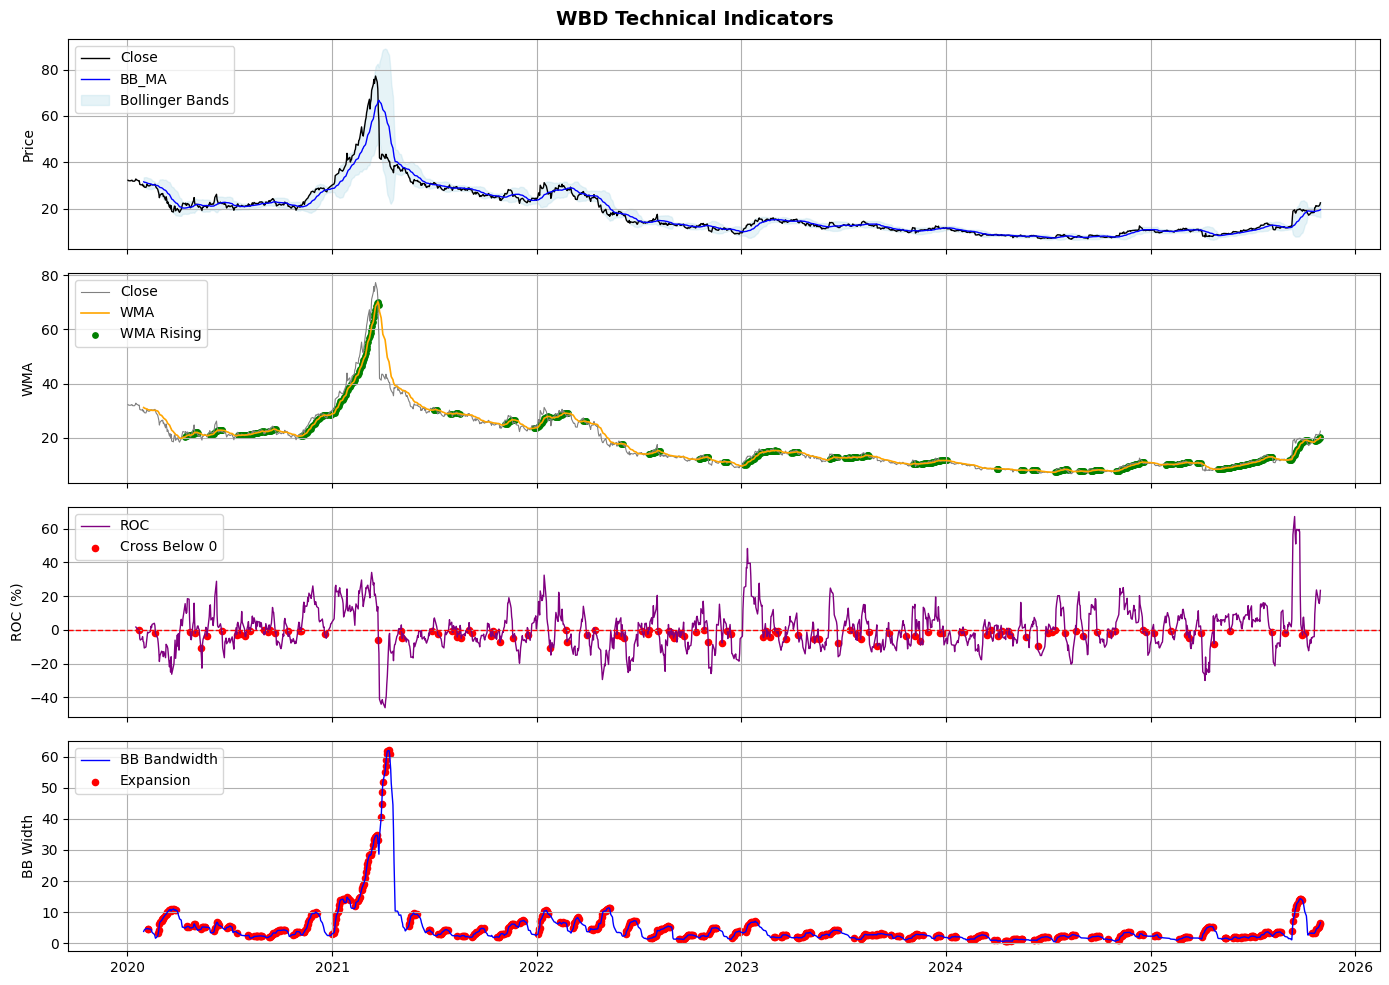

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------
symbol = "WBD"
start_date = "2020-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.dropna(inplace=True)

# -------------------------
# Parameters
# -------------------------
BB_PERIOD = 20
BB_SHIFT = 5
BB_STD = 2
ROC_PERIOD = 10
ROC_SHIFT = 5
WMA_PERIOD = 20
WMA_SHIFT = 5
ROC_LEVEL = 0

# -------------------------
# Indicator Calculations
# -------------------------
# Bollinger Bands
df['BB_MA'] = df['Close'].rolling(window=BB_PERIOD).mean()
df['BB_Upper'] = df['BB_MA'] + BB_STD * df['Close'].rolling(window=BB_PERIOD).std()
df['BB_Lower'] = df['BB_MA'] - BB_STD * df['Close'].rolling(window=BB_PERIOD).std()

# WMA (Weighted Moving Average)
weights = np.arange(1, WMA_PERIOD + 1)
df['WMA'] = df['Close'].rolling(WMA_PERIOD).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)

# ROC (Rate of Change)
df['ROC'] = (df['Close'] - df['Close'].shift(ROC_PERIOD)) / df['Close'].shift(ROC_PERIOD) * 100

# Signals
df['ROC_Cross_Below_Level'] = (df['ROC'].shift(1) >= ROC_LEVEL) & (df['ROC'] < ROC_LEVEL)
df['WMA_Rising'] = df['WMA'] > df['WMA'].shift(WMA_SHIFT)
df['BB_Expansion'] = (df['BB_Upper'] - df['BB_Lower']) > (df['BB_Upper'] - df['BB_Lower']).shift(BB_SHIFT)

# -------------------------
# Plotting
# -------------------------
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
fig.suptitle(f"{symbol} Technical Indicators", fontsize=14, fontweight='bold')

# --- Price + Bollinger Bands ---
axes[0].plot(df.index, df['Close'], label='Close', color='black', linewidth=1)
axes[0].plot(df.index, df['BB_MA'], label='BB_MA', color='blue', linewidth=1)
axes[0].fill_between(df.index, df['BB_Upper'], df['BB_Lower'], color='lightblue', alpha=0.3, label='Bollinger Bands')
axes[0].set_ylabel("Price")
axes[0].legend(loc='upper left')
axes[0].grid(True)

# --- Weighted Moving Average ---
axes[1].plot(df.index, df['Close'], label='Close', color='gray', linewidth=0.8)
axes[1].plot(df.index, df['WMA'], label='WMA', color='orange', linewidth=1.2)
axes[1].scatter(df.index[df['WMA_Rising']], df['WMA'][df['WMA_Rising']], color='green', label='WMA Rising', s=15)
axes[1].set_ylabel("WMA")
axes[1].legend(loc='upper left')
axes[1].grid(True)

# --- ROC (Rate of Change) ---
axes[2].plot(df.index, df['ROC'], label='ROC', color='purple', linewidth=1)
axes[2].axhline(ROC_LEVEL, color='red', linestyle='--', linewidth=1)
axes[2].scatter(df.index[df['ROC_Cross_Below_Level']], df['ROC'][df['ROC_Cross_Below_Level']], color='red', s=20, label='Cross Below 0')
axes[2].set_ylabel("ROC (%)")
axes[2].legend(loc='upper left')
axes[2].grid(True)

# --- Bollinger Band Expansion ---
bandwidth = df['BB_Upper'] - df['BB_Lower']
axes[3].plot(df.index, bandwidth, color='blue', label='BB Bandwidth', linewidth=1)
axes[3].scatter(df.index[df['BB_Expansion']], bandwidth[df['BB_Expansion']], color='red', s=20, label='Expansion')
axes[3].set_ylabel("BB Width")
axes[3].legend(loc='upper left')
axes[3].grid(True)

plt.tight_layout()
plt.show()
